In [ ]:
!nvidia-smi

Sat Oct 26 18:20:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
! git clone https://huggingface.co/openai-community/gpt2

fatal: destination path 'gpt2' already exists and is not an empty directory.


In [ ]:
! ls gpt2/

64-8bits.tflite  flax_model.msgpack	 onnx		    tf_model.h5
64-fp16.tflite	 generation_config.json  pytorch_model.bin  tokenizer_config.json
64.tflite	 merges.txt		 README.md	    tokenizer.json
config.json	 model.safetensors	 rust_model.ot	    vocab.json


# **Загрузка модели**

In [1]:
import transformers
import torch

import random
import re
from typing import List
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2Model, GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device = "cpu"

In [21]:
model = AutoModelForCausalLM.from_pretrained("gpt2")#, torch_dtype=torch.float64

In [22]:
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': "<|endoftext|>"})

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1

In [8]:
tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [6]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt").to(device)
outputs = model(**inputs)

In [10]:
outputs.logits.shape

torch.Size([1, 6, 50257])

In [11]:
output = model.generate(**inputs)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [12]:
output

tensor([[15496,    11,   616,  3290,   318, 13779,    13,   314,  1101,   407,
          1654,   611,   673,   338,   257, 26188,   393,   407,    13,   314]],
       device='cuda:0')

In [13]:
[tokenizer.decode(x) for x in output.detach()]

["Hello, my dog is cute. I'm not sure if she's a puppy or not. I"]

# **SFT**

**Задание:**

1. Разобраться, как правильно подать для обучения промпт и ответ модели. Описать входящие токены и таргеты для инструктивного датасета.

2. Написать train-loop для инструктивного датасета.  

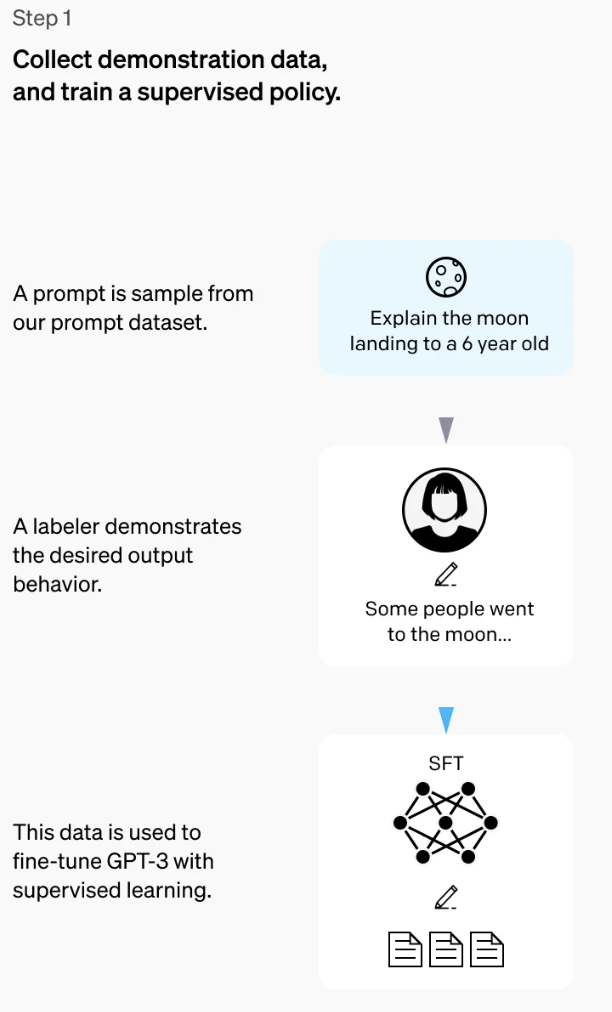

In [ ]:
from IPython.display import Image
Image('imgs/step1.png')

In [6]:
import pandas as pd
from torch import nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
### посмотреть на природу инструктивных данных, как они выглядят,
### подробно рассмотреть пару примеров из разных категорий

**Данные:**

Prompt - инструкция

Category - тип задачи (ответ на вопрос, суммаризация, креатив (придумать что-либо) и т.д.)

Original_response - Верный ответ

Response-1,2 - генерации моделей, чтобы определить какая из них лучше, нужно размечать их через большую LLM. Для простоты, давайте считать что response-2 хуже чем original_response и хуже response-1.


In [7]:
sft_df = pd.read_parquet('argilla_df.parquet')

In [21]:
sft_df

,prompt,response-1,response-2,category,original_response,external_id
0,What is Depreciation,What is Depreciation – 10 Important Facts to K...,What is Depreciation on a Car?\nDepreciation i...,open_qa,Depreciation is the drop in value of an asset ...,518
1,What do you know about the city of Aberdeen in...,"Aberdeen, the city in which I've lived for the...","As an AI language model, I don't have personal...",open_qa,Aberdeen is a city located in the North East o...,351
2,Describe thunderstorm season in the United Sta...,Describe thunderstorm season in the United Sta...,Describe thunderstorm season in the United Sta...,information_extraction,Thunderstorm season in the United States and C...,10567
3,"When did Peloton IPO?\nOn September 26, 2019, ...",When did Peloton IPO?\nPeloton launched its in...,When did Peloton IPO?\nPeloton IPO'd on May 26...,closed_qa,Peloton became a public company via an initial...,12412
4,What is the best way to answer an interview qu...,The best way to answer an interview question m...,Some of the best ways to answer an interview q...,creative_writing,The first recommended step is to ask clarifyin...,2521
...,...,...,...,...,...,...
7396,How do i accept the change,How do i accept the change in my life\nAccepti...,I's a great opportunity to improve. The only t...,brainstorming,Embrace the change and see the difference,15010
7397,Extract the teams that the footballer Sócrates...,Extract the teams that the footballer Sócrates...,Extract the teams that the footballer Sócrates...,information_extraction,"Brazil, Botafogo-SP, Corinthians, Fiorentina",9970
7398,Without quoting directly from the text give me...,Without quoting directly from the text give me...,Without quoting directly from the text give me...,summarization,"Brendon Small is a stand-up comedian, Creator...",14205
7399,Is Killing is Sin ? Is it ture,Is Killing is Sin ? Is it ture?\nKilling can b...,Is Killing is Sin ? Is it ture?\nKilling is no...,brainstorming,Killing a human being should not be sin becaus...,11253


In [26]:
sft_df.loc[0]["original_response"]

"Depreciation is the drop in value of an asset due to wear and tear, age and obsolescence (going out of date) as recorded in an organization's financial records."

In [28]:
len(sft_df)//3

2467

In [8]:
sft_df = sft_df[:2467]

In [30]:
sft_df.iloc[0]['prompt']

'What is Depreciation'

In [31]:
sft_df.iloc[0]['original_response']

"Depreciation is the drop in value of an asset due to wear and tear, age and obsolescence (going out of date) as recorded in an organization's financial records."

In [9]:
from torch.utils.data import Dataset
from typing import Dict, Sequence, List, Iterator, Tuple

IGNORE_INDEX: int = -100
pad_token_id = 60000

def _tokenize_fn(text: str, max_length: int, tokenizer: transformers.PreTrainedTokenizer) -> List[int]:
    return tokenizer(
        text,
        max_length=max_length,
        truncation=True,
        add_special_tokens=False,
    )['input_ids']


In [10]:
class SupervisedDataset(Dataset):
    """Dataset for supervised fine-tuning."""
    def __init__(self, dataset, tokenizer: transformers.PreTrainedTokenizer):
        super(SupervisedDataset, self).__init__()
        self.tokenizer = tokenizer

        bos_token = tokenizer.bos_token if tokenizer.bos_token is not None else ''
        self.sources = [f"{bos_token}{sample[0]}" for sample in dataset]
        self.targets = [f"{sample[1]}{tokenizer.eos_token}" for sample in dataset]

    def __len__(self) -> int:
        return len(self.sources)


    def __getitem__(self, i: int) -> Dict[str, List[int]]:
        source_ids = _tokenize_fn(self.sources[i], self.tokenizer.model_max_length, self.tokenizer)
        target_ids = _tokenize_fn(self.targets[i], self.tokenizer.model_max_length - len(source_ids), self.tokenizer)
        input_ids = torch.tensor(source_ids + target_ids)

        labels =  torch.tensor([IGNORE_INDEX] * (len(source_ids)-1) + target_ids + [pad_token_id])

        return dict(input_ids=input_ids,
                    labels=labels)

Depreciation is the drop in value of an asset due to wear and tear, age and obsolescence (going out of date) as recorded in an organization's financial records.


In [11]:
from torch.utils.data import Dataset, DataLoader, Sampler
from typing import Dict, Sequence, List, Iterator, Tuple

In [12]:
train_batch = SupervisedDataset(
    dataset=sft_df[:200][['prompt', 'original_response']].values,
    tokenizer=tokenizer,
)

In [13]:
train_batch_loader = DataLoader(
    dataset=train_batch,
    batch_size=1,
    shuffle=False,
)

{'input_ids': tensor([[50256,  2061,   318,  2129, 33950, 12156, 33950,   318,   262,  4268,
            287,  1988,   286,   281, 11171,  2233,   284,  5806,   290, 11626,
             11,  2479,   290, 10201, 16850,   594,   357,  5146,   503,   286,
           3128,     8,   355,  6264,   287,   281,  4009,   338,  3176,  4406,
             13, 50256]]),
 'labels': tensor([[ -100,  -100,  -100,  -100, 12156, 33950,   318,   262,  4268,   287,
           1988,   286,   281, 11171,  2233,   284,  5806,   290, 11626,    11,
           2479,   290, 10201, 16850,   594,   357,  5146,   503,   286,  3128,
              8,   355,  6264,   287,   281,  4009,   338,  3176,  4406,    13,
          50256, 60000]])}

In [14]:
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [15]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-6)
N_ITERATIONS = 10
cur_iteration = 0
loss_values = []
for x in train_batch_loader:
    if cur_iteration == N_ITERATIONS:
        break

    model.train()
    input_tokens = x["input_ids"].to(device)
    labels = x["labels"].clone().to(device)
    labels[labels == tokenizer.pad_token_id] = -100
    labels[labels == pad_token_id] = -100
    output_logits = model(input_ids=input_tokens).logits.permute(0, 2, 1)

    loss_value = loss(output_logits, labels)

    print(f"Loss value: {loss_value.item()}")
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()

    model.eval()
    cur_iteration += 1
    loss_values.append(loss_value.cpu().detach().numpy())

Loss value: 3.62373948097229
Loss value: 3.1800830364227295
Loss value: 0.9697020649909973
Loss value: 1.3576908111572266
Loss value: 3.5409579277038574
Loss value: 3.1446051597595215
Loss value: 2.769289016723633
Loss value: 2.3828418254852295
Loss value: 3.045948028564453
Loss value: 2.2044146060943604


# **Reward Model**


**Задание: Reward model**
1. Разобраться как формируется датасет. Какие примеры считаем положительными, какие отрицательными.
2. Написать train-loop для reward модели.

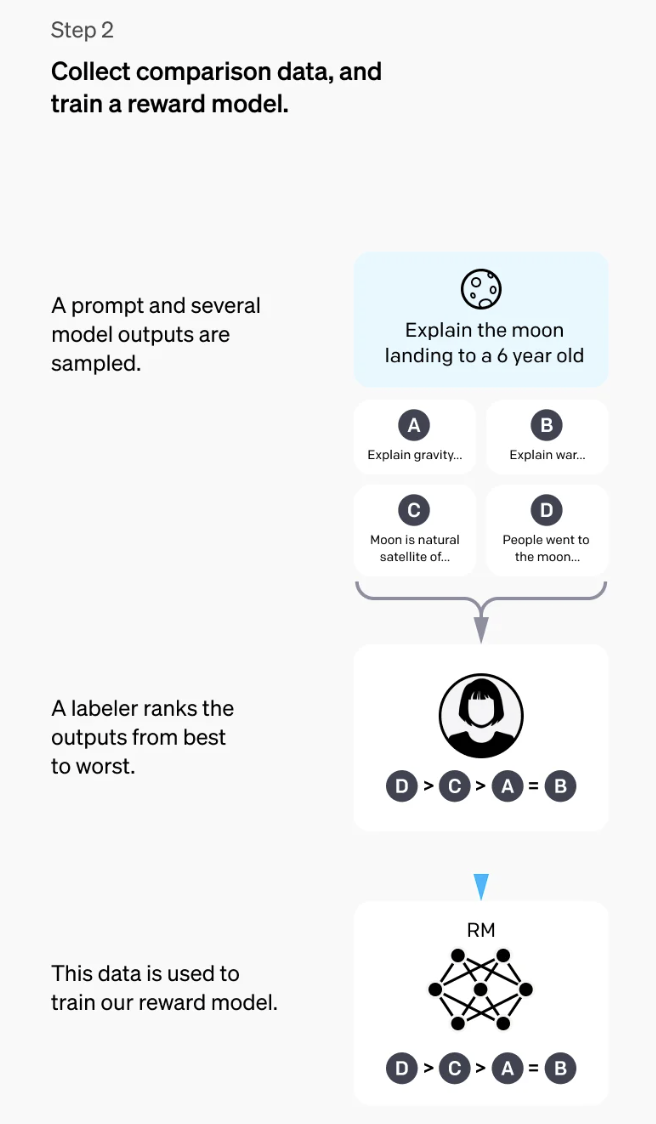

In [ ]:
Image('imgs/step2.png')

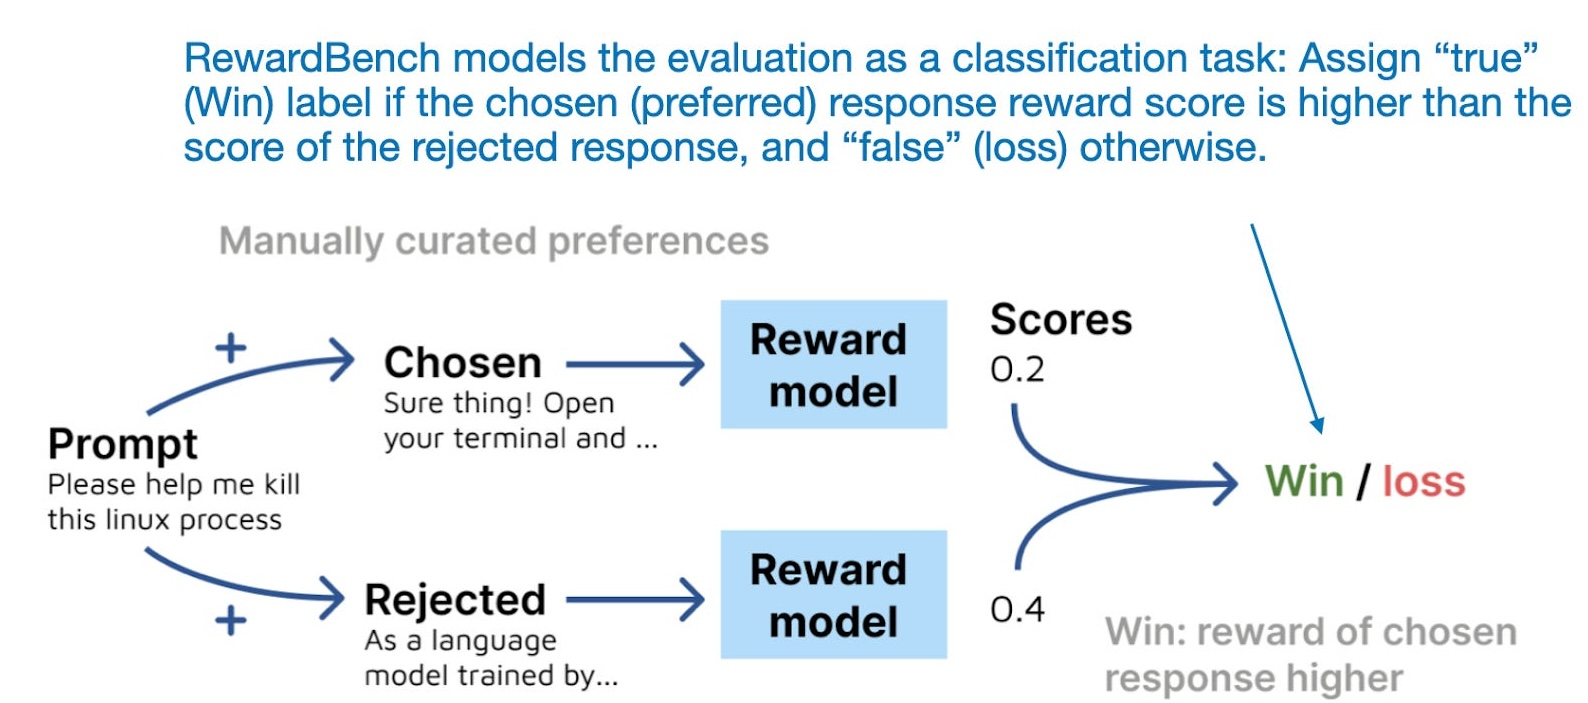

In [ ]:
Image('imgs/reward_model_image.jpeg')

In [ ]:
import pandas as pd

In [16]:
rm_df = pd.read_parquet('argilla_df.parquet')

In [17]:
rm_df = rm_df[2467:]

In [ ]:
rm_df

,prompt,response-1,response-2,category,original_response,external_id
2467,Name five countries in the Northern Hemisphere,1. United States\n2. Canada\n3. China\n4. Japa...,Name five countries in the Northern Hemisphere...,brainstorming,"Canada, France, India, Finland and Turkey are ...",1462
2468,Classify the following as being either being a...,hammerhead: type of shark\neagle: type of bird...,"Sawtooth, blacktip, and osprey are types of fi...",classification,"Hammerhead, tiger, sawtooth, blacktip, and gre...",4752
2469,Give me 3 totally distinct ways to eat a banana,1. As a straight up snack or dessert.\n2. As a...,Give me 3 totally distinct ways to eat a banan...,brainstorming,Peel and take bites of the whole banana; cut u...,6158
2470,Can you summarize the Korematsu case?\nKoremat...,Can you summarize the Korematsu case?\nKoremat...,Can you summarize the Korematsu case?\nThe Kor...,summarization,Korematsu v United States was a Supreme Court ...,14175
2471,Explain different pizza styles,Neopolitan style: This is a type of pizza that...,"There are several different styles of pizza, e...",brainstorming,New York style pizza is composed of a thin cru...,14413
...,...,...,...,...,...,...
7396,How do i accept the change,How do i accept the change in my life\nAccepti...,I's a great opportunity to improve. The only t...,brainstorming,Embrace the change and see the difference,15010
7397,Extract the teams that the footballer Sócrates...,Extract the teams that the footballer Sócrates...,Extract the teams that the footballer Sócrates...,information_extraction,"Brazil, Botafogo-SP, Corinthians, Fiorentina",9970
7398,Without quoting directly from the text give me...,Without quoting directly from the text give me...,Without quoting directly from the text give me...,summarization,"Brendon Small is a stand-up comedian, Creator...",14205
7399,Is Killing is Sin ? Is it ture,Is Killing is Sin ? Is it ture?\nKilling can b...,Is Killing is Sin ? Is it ture?\nKilling is no...,brainstorming,Killing a human being should not be sin becaus...,11253


In [19]:
from torch.utils.data import Dataset
from typing import Dict, Sequence, List, Iterator, Tuple

IGNORE_INDEX: int = -100
bos_token_id = 50256

def _tokenize_fn(text: str, max_length: int, tokenizer: transformers.PreTrainedTokenizer) -> List[int]:
    return tokenizer(
        text,
        max_length=max_length,
        truncation=True,
        add_special_tokens=False,
    )['input_ids']


class RewardDataset(Dataset):
    """Dataset for supervised fine-tuning."""
    def __init__(self, dataset, tokenizer: transformers.PreTrainedTokenizer):
        super(RewardDataset, self).__init__()
        self.tokenizer = tokenizer

        bos_token = tokenizer.bos_token if tokenizer.bos_token is not None else ''

        self.chosen = [f"{bos_token}{sample[0]}\n#####answer: {sample[1]}" for sample in dataset]
        self.rejected = [f"{bos_token}{sample[0]}\n#####answer: {sample[2]}" for sample in dataset]

    def __len__(self) -> int:
        return len(self.chosen)

    def __getitem__(self, i: int) -> Dict[str, List[int]]:
        chosen_ids = _tokenize_fn(self.chosen[i], self.tokenizer.model_max_length, self.tokenizer)
        rejected_ids = _tokenize_fn(self.rejected[i], self.tokenizer.model_max_length, self.tokenizer)

        min_len = min(len(chosen_ids), len(rejected_ids))

        return dict(
            input_ids_chosen= torch.tensor(chosen_ids[:min_len] + [bos_token_id]),
            input_ids_rejected=  torch.tensor(rejected_ids[:min_len] + [bos_token_id])
        )


In [20]:
train_rm = RewardDataset(
    dataset=rm_df[['prompt', 'original_response', 'response-2']].values,
    tokenizer=tokenizer,
)

In [ ]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    'gpt2',
    torch_dtype=torch.float64,
)

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [27]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-6)
OUTPUT_SIZE = 256
DEVICE = 'cuda'
N_ITERATIONS = 30
cur_iteration = 0
for x in train_rm:
    if cur_iteration == N_ITERATIONS:
        break

    model.train()

    chosen_input = x["input_ids_chosen"].to(device)
    rejected_input = x["input_ids_rejected"].to(device)

    chosen_output = model(chosen_input).logits
    rejected_output = model(rejected_input).logits

    loss_value = -nn.functional.logsigmoid(chosen_output - rejected_output).mean()


    print(f"Loss value: {loss_value.item()}")
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()

    model.eval()
    cur_iteration += 1

Loss value: 11.813584327697754
Loss value: 13.643097877502441
Loss value: 13.901446342468262
Loss value: 13.660490036010742
Loss value: 25.711957931518555
Loss value: 10.324445724487305
Loss value: 9.891250610351562
Loss value: 8.7041597366333
Loss value: 10.35392951965332
Loss value: 9.316160202026367
Loss value: 12.418915748596191
Loss value: 6.090398788452148
Loss value: 10.64460277557373
Loss value: 12.971867561340332
Loss value: 8.853108406066895
Loss value: 10.453744888305664
Loss value: 10.182621955871582
Loss value: 9.694485664367676
Loss value: 8.6405611038208
Loss value: 32.13148880004883
Loss value: 24.679582595825195
Loss value: 10.263526916503906
Loss value: 18.593093872070312
Loss value: 8.667505264282227
Loss value: 19.658300399780273
Loss value: 9.090363502502441
Loss value: 9.607972145080566
Loss value: 19.794048309326172
Loss value: 7.237200736999512
Loss value: 28.218164443969727


# **DPO**

Написать функцию для получения лосса DPO. Разобраться, в чем преимущество этого подхода перед PPO. И почему в этом подходе не нужна reward модель.

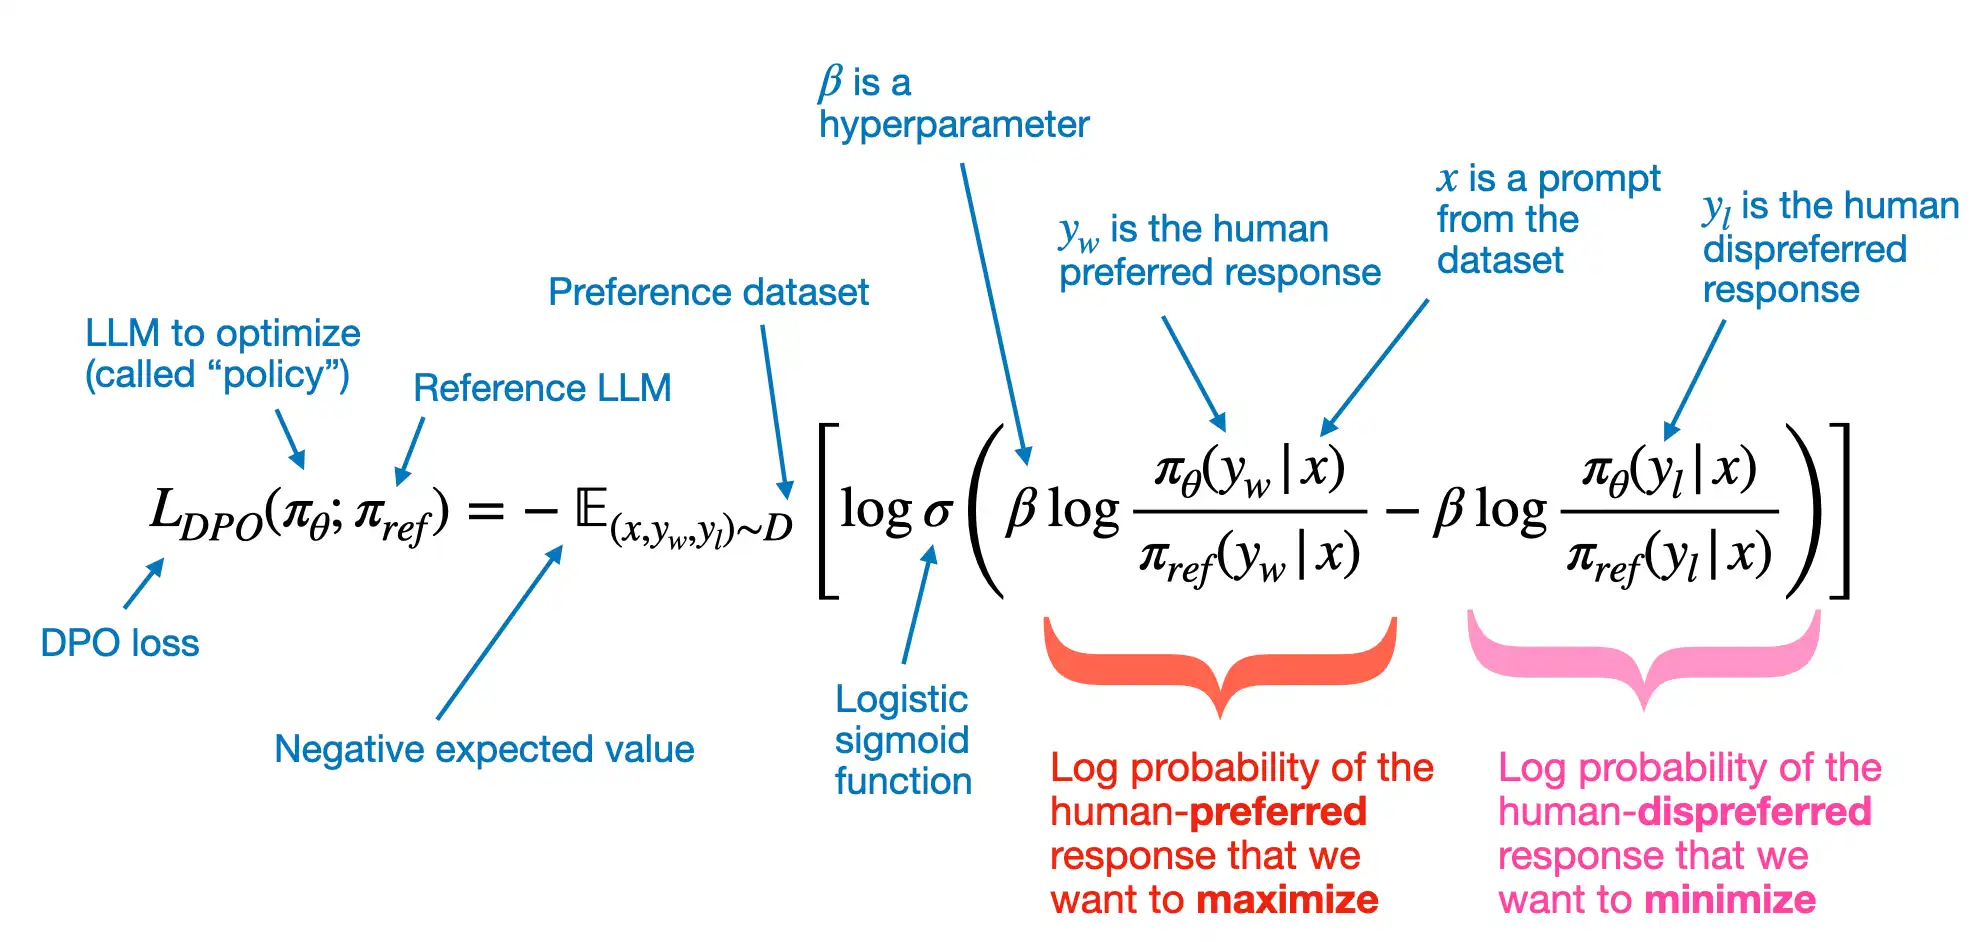

In [ ]:
Image('imgs/dpo_image.png')

In [ ]:
import torch.nn.functional as F

def dpo_loss(pi_logps, ref_logps, yw_idx, yl_idx, beta):
    '''
    pi_logps: policy logprobs, shape (B, )
    ref_logps: reference model logprobs, shape (B, )
    yw_idx: preferred completion indices, shape (T, )
    yl_idxs: dispreferred copletion indicies, shape (T, )
    beta: temperature controlling srtength of KL penalty

    Each pair of (yw_idx[i], yl_idx[i] represents the indices of a single preferance pair)

    reference - after SFT, fixed model

    '''

    pi_yw_logps, pi_yl_logps =  ### your code ###
    ref_yw_logps, ref_yl_logps =  ### your code ###

    pi_logratios =  ### your code ###
    ref_logratios =  ### your code ###

    losses =  ### your code ###
    rewards =  ### your code ###

    return losses, rewards